In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [23]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

In [11]:
class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [18]:
# Training settings
input_size=(3,28,28,)
batch_size=64
test_batch_size=1000
epochs=10
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [14]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [33]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor() 
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           GrayscaleToRgb(),
                           transforms.ToTensor()                          
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [34]:
imgs,labels = next(iter(train_loader))
print(imgs.shape)

torch.Size([64, 3, 28, 28])


In [36]:
labels

tensor([7, 5, 9, 1, 1, 8, 4, 2, 3, 3, 5, 9, 7, 3, 9, 9, 0, 6, 7, 0, 0, 8, 4, 0,
        1, 3, 1, 0, 6, 2, 7, 1, 5, 7, 5, 3, 2, 0, 4, 0, 2, 7, 7, 9, 4, 8, 8, 9,
        9, 6, 3, 1, 8, 4, 6, 2, 8, 6, 7, 2, 9, 7, 0, 7])

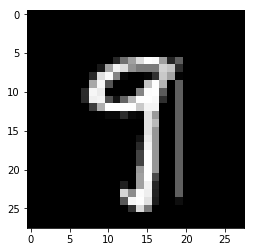

In [41]:
plt.imshow(np.transpose(imgs[2], (1,2,0) ) )

In [42]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()

In [43]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             760
         MaxPool2d-2           [-1, 10, 12, 12]               0
              ReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 8, 8]           5,020
         MaxPool2d-5             [-1, 20, 4, 4]               0
         Dropout2d-6             [-1, 20, 4, 4]               0
            Linear-7                   [-1, 50]          16,050
              ReLU-8                   [-1, 50]               0
           Dropout-9                   [-1, 50]               0
           Linear-10                   [-1, 10]             510
Total params: 22,340
Trainable params: 22,340
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 0.09
Estimated Tot

In [44]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310507
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.319052
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.288078
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.185427
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.949314
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.566168
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.240254
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.034707
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.917328
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.700205

Test set: Average loss: 0.0004, Accuracy: 8852/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.830391
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.558885
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.824896
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.704517
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.746356
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.685877
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.547405
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.693664
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.548298
T

In [45]:
torch.save(model.state_dict(),"conv_for_domain_adaptation.pt")